# Predicting Time Series Dataset with ARIMA
This notebook provides the method to predict time series dataset with ARIMA model. The approach undertaken is based on Box-Jenkins methodology. <br>
ARIMA is an integrated model of <br>

**AR**: Auto Regressive, defined by lag order,p (no. of lagged observations considered) <br>
**I** : Integrative, defined by differencing degree,d (no. of times values are differentiated to make time-series data stationary)<br>
**MA**: Moving Average, defined by parameter,q (size of moving average window)<br>    
<br>


## 1. Import necessary Python Libraries

In [17]:
!pip3 install quandl
!pip3 install statsmodels
import quandl
from datetime import date,timedelta
import math
import itertools
import pandas as pd
import statsmodels.tsa.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.stats.diagnostic import acorr_ljungbox as ljbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import calendar
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')





## 2. Explore Dataset 
This dataset records *Price of Gold in London/Afternoon Fixing/1 oz. Fine Gold in EUR* is obtained from Deutsche Bundesbank Data Repository, via the Quandl API. The dataset is refreshed monthly. A summary of the dataset can be obtained, where the total number of records, 5 first and last records, and the dataset's statistical values are displayed.

In [18]:
quandl.read_key()
s=quandl.ApiConfig.api_key
quandl.ApiConfig.api_key=s.strip()

end_d = date.today()
interval = end_d - timedelta(days=10*365)
start_d = str(interval)

data=quandl.get("BUNDESBANK/BBEX3_M_XAU_EUR_EA_AC_C07", start_date=start_d, end_date=end_d) 
print(data.index)
print("Dataset Size (rows, columns)", data.shape)
#print("Total number of rows", data.count() + 1)
print("#########")
print("First and Last 5 rows")
print(data.head())
print(data.tail())
print("#########")
print("Statistical Values")
print(data.describe())

DatetimeIndex(['2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29',
               ...
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31'],
              dtype='datetime64[ns]', name='Date', length=119, freq=None)
Dataset Size (rows, columns) (119, 1)
#########
First and Last 5 rows
               Value
Date                
2011-05-31  1055.389
2011-06-30  1062.081
2011-07-31  1101.486
2011-08-31  1225.120
2011-09-30  1286.321
               Value
Date                
2020-11-30  1574.840
2020-12-31  1524.967
2021-01-31  1534.698
2021-02-28  1494.959
2021-03-31  1444.208
#########
Statistical Values
             Value
count   119.000000
mean   1172.967521
std     180.582948
min     894.123000
25%    1056.264000
50%    1121.713000
75%    127

## 4. Autocorrelation plot and Partial Autocorrelation plot
### Random or Correlated?
The Autocorrelation Function (ACF) plot is used to determine if the elements in this time series data are correlated to each other or random. 

<p><center>'The autocorrelation at lag <i>k</i> is a measure of how much the value of X<sub>t</sub> depends on the value of X<sub>t-k</sub>'</center></p>

<p>The Partial Autocorrelation Function(PACF) plot, on the other hand, is useful for a reference of the order <i>p</i>, the Auto-regressive order.</p>

<p><div align="center">'The partial autocorrelation at lag <i>k</i> is autocorrelation between X<sub>t</sub> and X<sub>t-k</sub> that is not accounted for by lags <i>1</i> to <i>k-1</i>'</div><br></p>
<div align="right">
<a href="https://doi.org/10.18434/M32189">NIST Engineering Statistics Handbook</a> </div></p>

<br>
<p>As expected, ACF(0) = 1.0, because the value correlates at the maximum to itself at timelag 0. The blue area is the 95% confidence interval band, with standard deviation computed using Bartlett's formula and a moving average model is assumed for the data. Statistically significant spikes, i.e. spikes which are beyond the confidence band, can be found up to time lag 7 which indicate a strong autocorrelation pattern. The positive correlation declines slowly with a cutoff at time lag 17, and becomes increasingly negative correlated thereafter. These spikes are unlikely to be generated by chance but rather they indicate high positive dependency with each other. Alternatively stated,these spikes indicate that when the price of gold is on an uprising trend, the adjacent and near-adjacent prices will increase as well. Similarly, when the trend is reversed, the adjacent and near-adjacent prices will decrease. The autocorrelation pattern marks the high reliability of the predictions when the right model is chosen. </p> 

### AR, MA, or both (ARIMA)?
From the ACF plot, it can be inferred that an integrated **ARMA** or **ARIMA** model would be appropriate for the time series dataset because both plots show a slow decay from the first lag.<br>

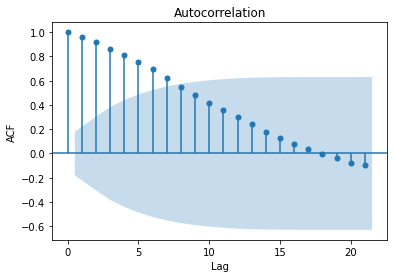

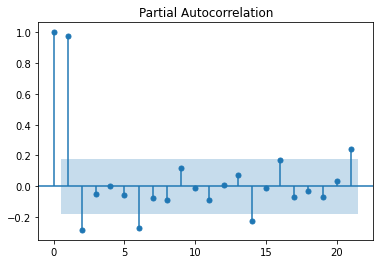

In [19]:
plot_acf(data)
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()
plot_pacf(data)
plt.show()

## 3. Transform Time Series Dataset to Stationary Dataset
The transformation of dataset to a stationary one is required to ensure that the statistical properties such as mean and variances remain constant over time. This is important because the statistical properties would be required to validate our forecast and/or prediction. <br>
Time differencing is done iteratively until p-values approaches 0 , i.e. p<<0.05 in Ljung-Box Test and ACF cuts off at lag 1. 


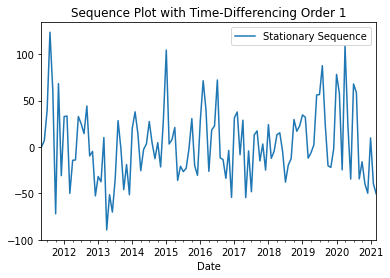

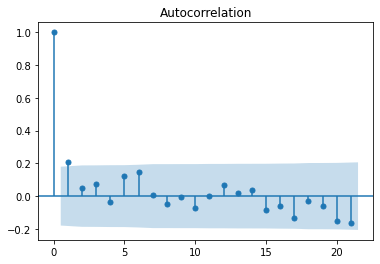

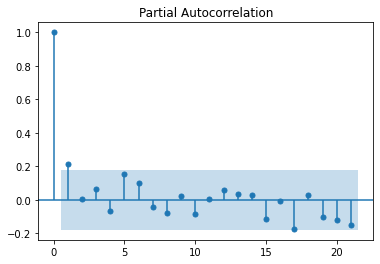

,lb_stat,lb_pvalue
1,5.353564,0.020680
2,5.628376,0.059953
3,6.296124,0.098059
4,6.432591,0.169088
5,8.322034,0.139358
6,11.122552,0.084662
7,11.130700,0.133019
8,11.436013,0.178196
9,11.438053,0.246873
10,12.191266,0.272460


In [20]:
differenced_data = data.copy()
#For d=1
for i in range(data.shape[0]):
    if i==0:
        differenced_data['Value'][i] = 0
    else:
        differenced_data['Value'][i] = data['Value'][i] - data['Value'][i-1] 

stationary_timeseries = differenced_data['Value']
stationary_timeseries.plot(label='Stationary Sequence')
plt.title('Sequence Plot with Time-Differencing Order 1')
plt.legend()
plt.show()
plot_acf(differenced_data)
plt.show()
plot_pacf(differenced_data)
plt.show()
ljbox(differenced_data, lags=[10], period=12, return_df=True)

             Value
Date              
2011-05-31   0.000
2011-06-30   0.000
2011-07-31  32.713
2011-08-31  84.229
2011-09-30 -62.433
             Value
Date              
2020-11-30 -23.688
2020-12-31 -10.190
2021-01-31  59.604
2021-02-28 -49.470
2021-03-31 -11.012
            Value
count  119.000000
mean    -0.482714
std     49.125334
min   -133.208000
25%    -32.054500
50%      2.037000
75%     30.594500
max    140.289000


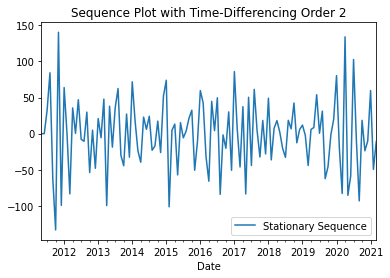

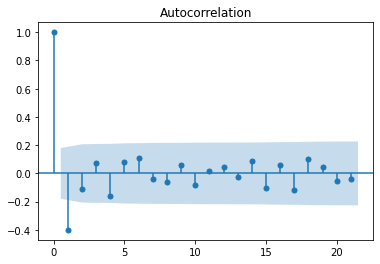

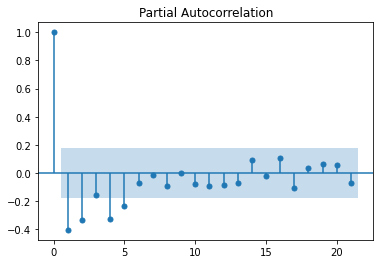

,lb_stat,lb_pvalue
1,19.551524,0.000010
2,21.110845,0.000026
3,21.820797,0.000071
4,25.154986,0.000047
5,26.008951,0.000089
6,27.461059,0.000119
7,27.652366,0.000254
8,28.150087,0.000447
9,28.569621,0.000766
10,29.487995,0.001038


In [21]:
#For d=2
differenced_data = data.copy()
#For d=1
for i in range(data.shape[0]):
    if i==0:
        differenced_data['Value'][i] = 0
    else:
        differenced_data['Value'][i] = data['Value'][i] - data['Value'][i-1] 
#For d=2
differenced_data2 = differenced_data.copy()
for i in range(differenced_data2.shape[0]):
    if i==0 or i==1:
        differenced_data2['Value'][i] = 0
    else:
        differenced_data2['Value'][i] = differenced_data['Value'][i] - differenced_data['Value'][i-1] 

        
print(differenced_data2.head())
print(differenced_data2.tail())
print(differenced_data2.describe())        
stationary_timeseries = differenced_data2['Value']
stationary_timeseries.plot(label='Stationary Sequence')
plt.title('Sequence Plot with Time-Differencing Order 2')
plt.legend()
plt.show()
plot_acf(differenced_data2)
plt.show()
plot_pacf(differenced_data2)
plt.show()
ljbox(differenced_data2, lags=[10], period=12, return_df=True) #p+q=2
#acf zero/negative at lag 1 at d = 2, p-value is small (p<0,05), hence no more differencing 

## 4. Determine orders for ARIMA Model
Using in-built arma_order_select_ic command, p,q can be determined where a gridsearch is done by looking for the combination of p and q values with the lowest Aikake Information Criterion, a scoring model based on log-likelihood. The AIC formula is given by:<br>
<p>
<div align="center"> <i>AIC = (-2/N * LL) + 2 * (k/N),</i> </div></p>
<p>where N is number of examples in the training dataset, <br>
    LL is the log-likelihood of the model on the training dataset, <br>
    and k is the number of parameters in the model<br>

In [22]:
arma_order_select_ic(data, ic='aic') #p=2, q=1

{'aic':              0            1            2
 0  1577.396418  1442.625473  1456.204084
 1  1220.000389  1215.869790  1217.716936
 2  1215.412099  1214.085317  1219.460886
 3  1217.271898  1215.222225          NaN
 4  1218.157294  1216.431814  1217.700420,
 'aic_min_order': (2, 1)}

The p and q values are validated using my own code, which include d value and Bayesian Information Criterion (BIC) in the gridsearch. Similar to AIC, BIC scores a model based on a maximum likelihood estimation approach but with a larger penalty/score on the complexity of the model. A larger N, which measures the size of the dataset, increases the probability of BIC choosing the optimal model which reflect the observations with learning models. The best optimal model is a model with the lowest BIC score.<br>
The BIC formula is given by:
<p>
<div align="center"><i> BIC = (-2 * LL) + log(N)* (k),</i></div></p>
<p>
where N is number of examples in the training dataset,<br>
LL is the log-likelihood of the model on the training dataset,<br>
and k is the number of parameters in the model<br></p>
<p>
Using the AIC and BIC criteria, the order to be selected were (1,0,1) and (0,0,1)<br>
ARIMA Model to be chosen: ARIMA(1, 0, 1) - AIC:1217.0463772763421<br>
ARIMA Model to be chosen: ARIMA(0, 1, 2) - BIC:1226.479869263972<br></p>


In [23]:
#Validate using grid search to look for optimal ARIMA
AIC=[]
Order=[]
BIC=[]

#Test for 1st Order MA Model first
order=(0,0,1)
arima = ARIMA(differenced_data2, order=order)
result=arima.fit()
AIC.append(result.aic)
Order.append(order)
lowest_AIC=result.aic
order2select=order
lowest_BIC=result.bic   

p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for o in pdq:
    arima = ARIMA(differenced_data2, order=o)
    result=arima.fit()
    AIC.append(result.aic)
    BIC.append(result.bic)
    Order.append(o)
    if result.aic < lowest_AIC:
        lowest_AIC = result.aic   
        order2select=o
    if result.bic < lowest_BIC:
        lowest_BIC = result.bic
        order2select2=o

gridSearch_results = pd.DataFrame({"Order":Order, "AIC":AIC})
print(gridSearch_results)
print("ARIMA Model to be chosen: ARIMA{} - AIC:{}".format(order2select,lowest_AIC))
print("ARIMA Model to be chosen: ARIMA{} - BIC:{}".format(order2select2,lowest_BIC))

         Order          AIC
0    (0, 0, 1)  1219.075380
1    (0, 0, 0)  1267.564365
2    (0, 0, 1)  1219.075380
3    (0, 0, 2)  1217.225105
4    (0, 0, 3)  1219.190293
..         ...          ...
121  (4, 4, 0)  1475.449105
122  (4, 4, 1)  1403.024017
123  (4, 4, 2)  1341.728844
124  (4, 4, 3)  1355.530106
125  (4, 4, 4)  1366.283977

[126 rows x 2 columns]
ARIMA Model to be chosen: ARIMA(1, 0, 1) - AIC:1217.0463772763421
ARIMA Model to be chosen: ARIMA(0, 1, 2) - BIC:1226.479869263972


## 5. Forecast (Prediction includes 20% In-Sample Values for Validation) 

Validation error (Root Mean Square Error) is chosen to determine the best model.<br>
The best model with the lowest RMSE is:<br>
RMSE from AIC optimised model: 221.342

In [24]:


    
def add_months(sourcedate, months):
    #add to sourcedate by value contained in variable months
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return date(year, month, day)

#split into train, test data
partition = int(data.shape[0]*0.8)
train, test = differenced_data2[0:partition], differenced_data2[partition:data.shape[0]]

forecasts=[]
forecast_date=[]

observations=[]
obs_date=[]

start_d = test.index[0]
stringDate = str(start_d.date())
stringDate = stringDate.split('-')
y=int(stringDate[0])
m=int(stringDate[1])
d=int(stringDate[2])
end_d = add_months(date(y,m,d), 1)


#forward validation (in-sample forecast)
model = ARIMA(train, order=order2select)
model_fit=model.fit()
output = model_fit.forecast(steps=len(test))
history=data[:partition]
observations = data['Value'][partition:data.shape[0]]
obs_date = data.index[partition:data.shape[0]]

c=0
for elem in output:
    #reverse time differencing process
    f_value = elem + history.iloc[c-2]
    forecasts.append(f_value)
    forecast_date.append(add_months(date(y,m,d),c))
    c +=1
        
history.append(forecasts)    



#evaluate forecasts    
rmse = math.sqrt(mse (observations, forecasts))
print('RMSE from AIC optimised model: %.3f' %rmse)

#forward validation (in-sample forecast)
forecasts2=[]
forecast_date2=[]

observations2=[]
obs_date2=[]

model2 = ARIMA(train, order=order2select2)
model_fit2=model2.fit()
output2 = model_fit2.forecast(steps=len(test))
history2=data[:partition]
observations2 = data['Value'][partition:data.shape[0]]
obs_date2 = data.index[partition:data.shape[0]]

c=0
for elem in output2:
    #reverse time differencing process
    f_value2 = elem + history2.iloc[c-2]
    forecasts2.append(f_value2)
    forecast_date2.append(add_months(date(y,m,d),c))
    c +=1
    
history2.append(forecasts2)    



#evaluate forecasts    
rmse = math.sqrt(mse (observations2, forecasts2))
print('RMSE from BIC optimised model: %.3f' %rmse)




RMSE from AIC optimised model: 221.342
RMSE from BIC optimised model: 221.511


## 6. Prediction
Using the right ARIMA model to make prediction as shown in the graph.<br>


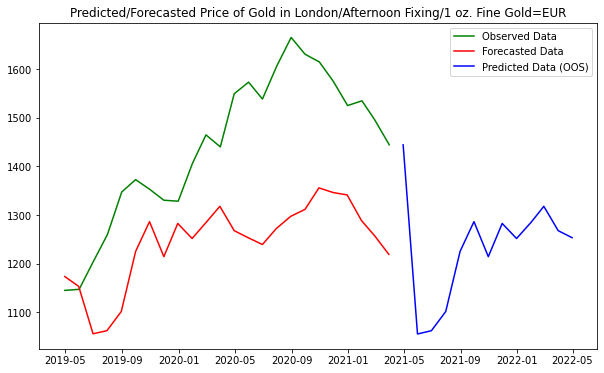

In [25]:
#predict
#create placeholder
predictions=[]
pred_date=[]

ar = ARIMA(differenced_data2,order=order2select)
start_d = test.index[-1]
stringDate = str(start_d.date())
stringDate = stringDate.split('-')
y=int(stringDate[0])
m=int(stringDate[1])
d=int(stringDate[2])
history=data[:]

pred = model_fit.predict(start=add_months(date(y,m,d), 0),end=add_months(date(y,m,d), 12), dynamic=True)
c=1
for elem in pred:
    p_value = elem + history.iloc[c-2]
    predictions.append(p_value)
    pred_date.append(add_months(date(y,m,d),c))
    c+=1
           

#plot 
plt.figure(figsize=(10,6))
plt.plot(obs_date,observations, 'g', label='Observed Data')
plt.plot(forecast_date,forecasts, 'r', label='Forecasted Data')
plt.plot(pred_date, predictions, 'b', label='Predicted Data (OOS)')
plt.legend()
plt.title('Predicted/Forecasted Price of Gold in London/Afternoon Fixing/1 oz. Fine Gold=EUR')
plt.show()
